<div style="text-align: center; font-family: Arial, sans-serif; margin-top: 50px;">
<h1 style="font-size: 36px; font-weight: bold; color: #4CAF50;">Mini-projet 4 - Méthode de la Matrice 2D</h1>
<h2 style="font-size: 20px; font-weight: bold; color: #4CAF50;">PHS3903</h2>
<h2 style="font-size: 20px; margin-bottom: 20px;">[Harbec/William, Leduc/Marc-Antoine, St-Onge/Émily]</h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">[2215754, 2198586, 2134102]</h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">[19 février 2025]</h2>
<h2 style="font-size: 16px; margin-bottom: 10px;">[Jérémie Villeneuve, Sean Molesky, Maksim Skorobogatiy]</h2>
</div>


# 1) Travail préparatoire

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

# Distribution de la température dans un appartement d'un immeuble aux plusieurs étages


# Équation de transfert de chaleur:
# k*(d^2 T(x,y)/dx^2 + d^2 T(x,y)/dy^2)+S=0


# Conditions aux limites:

# (1) Condition convective (de Robin) à x=0 et à x=Lx (faces externes du mur):
# -k*dT(x=0,y)/dx=-h*(T-Ta)
# -k*dT(x=L,y)/dx=h*(T-Ta)
Ta=-20; #oC

# (2) Condition de Dirichlet sur le plafond et sur le plancher
# T(x, y=0 ou y=Ly)=Tp
Tp=20; #oC

# Dimensions d'appartement
Lx=4; #[m]
Ly=2.4;  #[m]

# Parametres d'un mur d'isolation thermique
Lm=0.4; #m ; Épaisseur du mur en brique
km=0.85;#W/(m*K); La conductivité thermique de la brique
h=10; #W/(m^2*K); Coefficient de transfert thermique sur les surfaces extérieures du mur

# Paramètres de l'air qui remplit l'appartement
ka=0.024;

fact_ar = np.array([1.0, 0.5, 0.25, 0.125, 0.0625], dtype=np.double); # Matrice pleine
d_ar=np.zeros(fact_ar.size,dtype=np.double);
tini_ar=np.zeros(fact_ar.size,dtype=np.double);
tinv_ar=np.zeros(fact_ar.size,dtype=np.double);
mem_ar=np.zeros(fact_ar.size,dtype=np.double);
Tm_ar=np.zeros(fact_ar.size,dtype=np.double);
Err_ar=np.zeros(fact_ar.size-1,dtype=np.double);
d_Err_ar=np.zeros(fact_ar.size-1,dtype=np.double);

ci=-1;
for fact in fact_ar:
    ci=ci+1;
    d=0.1*fact;    #Pas de discrétisation en [m]
    print('Pas de discritization dx=dy=',d,'m')
    d_ar[ci]=d;
    Nx=int(np.rint(Lx/d+1)); # Nombre de nœuds le long de X
    Ny=int(np.rint(Ly/d+1)); # Nombre de nœuds le long de Y
    
    
    tic=time.time_ns();
    
    # Initialisation de la source de chaleur, de la conductivité thermique et de la matrice
    S=np.zeros((Ny,Nx),dtype=np.double);
    k=np.zeros((Ny,Nx),dtype=np.double);
    for i in np.arange(1,Ny+1,1): #i=1,..,Ny - numérotation des nœuds sur un maillage physique
        y=(i-1)*d;
        for j in np.arange(1,Nx+1,1): #j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x=(j-1)*d;
            
            # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL.
            # La source est intégrée dans les parties intérieures du mur à x=Lm et à x=Lx-Lm et
            # il occupe les tiers du mur dans la direction verticale
            dL=0.1;
            # q=1.0e3;# W/m^3;
            q = 2.0e4;
            if ((x<=Lm) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((x-Lm)/dL)**2);
            elif ((x>=(Lx-Lm)) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((Lx-Lm-x)/dL)**2);
            else:
                # À l'extérieur de l'élément chauffant
                S[i-1,j-1]=0.0;
            
            # L'espace de vie de l'appartement est délimité par
            # les parois d'épaisseur Lm à tous les quatre côtés
            if ((x<=Lm) or (x>=(Lx-Lm)) or (y<=Lm) or (y>=(Ly-Lm))):
                # À l'intérieur du mur
                k[i-1,j-1]=km;
            else:
                # À l'intérieurde de l'appartement
                k[i-1,j-1]=ka;
                
    # M=np.zeros((Nx*Ny,Nx*Ny),dtype=np.double);
    M = lil_matrix((Nx*Ny, Nx*Ny), dtype=np.double);
    b=np.zeros((Nx*Ny,1),dtype=np.double);
    T=np.zeros((Nx*Ny,1),dtype=np.double);
    Tr=np.zeros((Ny,Nx),dtype=np.double);
    
    for i in np.arange(1,Ny+1,1): 
        for j in np.arange(1,Nx+1,1): 
            # remplir la ligne pl de la matrice M
            pl=(i-1)*Nx+j;
            
            if (((i>1) and (i<Ny)) and ((j>1) and (j<Nx))):
                # noeud qui est strictement à l'intérieur de la cellule de simulation
                pc=pl;M[pl-1,pc-1]=-4; # contribution de noeud (i,j)
                pc=(i-1)*Nx+j-1;M[pl-1,pc-1]=1; # contribution de noeud (i,j-1)
                pc=(i-1)*Nx+j+1;M[pl-1,pc-1]=1; # contribution de noeud (i,j+1)
                pc=(i-2)*Nx+j;M[pl-1,pc-1]=1; # contribution de noeud (i-1,j)
                pc=(i)*Nx+j;M[pl-1,pc-1]=1; # contribution de noeud (i+1,j)
                b[pl-1]=-d**2*S[i-1,j-1]/k[i-1,j-1];
            elif (i==1):
                # noeud sur le plafond y=0
                pc=pl;M[pl-1,pc-1]=1; # contribution de noeud (1,j)
                b[pl-1]=Tp;
            elif (i==Ny):
                # noeud sur le plancher y=Ly
                pc=pl;M[pl-1,pc-1]=1; # contribution de noeud (Ny,j)
                b[pl-1]=Tp;
            elif (j==1):
                # noeud à la surface externe du mur x=0
                pc=pl;M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1]; # contribution de noeud (i,1)
                pc=(i-1)*Nx+j+1;M[pl-1,pc-1]=-4; # contribution de noeud (i,2)
                pc=(i-1)*Nx+j+2;M[pl-1,pc-1]=1; # contribution de noeud (i,3)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1];
            elif (j==Nx):
                # noeud à la surface externe du mur x=Nx
                pc=pl;M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1]; # contribution de noeud (i,Nx)
                pc=(i-1)*Nx+j-1;M[pl-1,pc-1]=-4; # contribution de noeud (i,Nx-1)
                pc=(i-1)*Nx+j-2;M[pl-1,pc-1]=1; # contribution de noeud (i,Nx-2)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1];
            
            ##### Condition de continuité mur intérieur #####
            elif (j==Lm/d+1) and (Lm/d<=i) and (i<=Ny-Lm/d):
                #noeud à la surface du mur interne
                pc=pl;M[pl-1,pc-1]=3*(km+ka)
                pc=(i-1)*Nx+j-1;M[pl-1,pc-1]=-4*km
                pc=(i-1)*Nx+j-2;M[pl-1,pc-1]=km
                pc=(i-1)*Nx+j+1;M[pl-1,pc-1]=-4*ka
                pc=(i-1)*Nx+j+2;M[pl-1,pc-1]=ka
                b[pl-1] = 0
            elif (j==Nx-Lm/d) and (Lm/d<=i) and (i<=Ny-Lm/d):
                # noeud à la surface du mur interne
                pc=pl;M[pl-1,pc-1]=3*(ka+km)
                pc=(i-1)*Nx+j-1;M[pl-1,pc-1]=-4*ka
                pc=(i-1)*Nx+j-2;M[pl-1,pc-1]=ka
                pc=(i-1)*Nx+j+1;M[pl-1,pc-1]=-4*km
                pc=(i-1)*Nx+j+2;M[pl-1,pc-1]=km
                b[pl-1] = 0
            elif (i==Lm/d+1) and (Lm/d<=j) and (j<=Nx-Lm/d):
                #Plafond
                pc=pl;M[pl-1,pc-1]=3*(km+ka)
                pc=(i-2)*Nx+j;M[pl-1,pc-1]=-4*km
                pc=(i-3)*Nx+j;M[pl-1,pc-1]=km
                pc=(i)*Nx+j;M[pl-1,pc-1]=-4*ka
                pc=(i+1)*Nx+j;M[pl-1,pc-1]=ka
                b[pl] = 0
            elif (i==Ny-Lm/d) and (Lm/d<=j) and (j<=Nx-Lm/d):
                #Plancher
                pc=pl;M[pl,pc]=3*(ka+km)
                pc=(i-2)*Nx+j;M[pl-1,pc-1]=-4*ka
                pc=(i-3)*Nx+j;M[pl-1,pc-1]=ka
                pc=(i)*Nx+j;M[pl-1,pc-1]=-4*km
                pc=(i+1)*Nx+j;M[pl-1,pc-1]=km
                b[pl] = 0
            else:
                print('Erreur dans la définition de la matrice de coefficients');

    toc=time.time_ns();
    tini_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    tic=time.time_ns();
    M_csr = M.tocsr();
    T_sparse = spsolve(M_csr, b.ravel());
    T = T_sparse.reshape((Nx*Ny,1));
    # T=np.linalg.solve(M,b);
    toc=time.time_ns();
    tinv_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    mem_ar[ci]=8*(Nx*Ny)**2;
    
    Tr=np.reshape(T,(Ny,Nx),order='C');
    
    Tm_ar[ci]=Tr[int(np.rint(Ly/d/2+1))-1,int(np.rint(Lx/d/2+1))-1]; # température au milieu du domaine de calcul



Pas de discritization dx=dy= 0.1 m
Pas de discritization dx=dy= 0.05 m
Pas de discritization dx=dy= 0.025 m
Pas de discritization dx=dy= 0.0125 m
Pas de discritization dx=dy= 0.00625 m


#  

# 2) Simulation numérique

## 1)

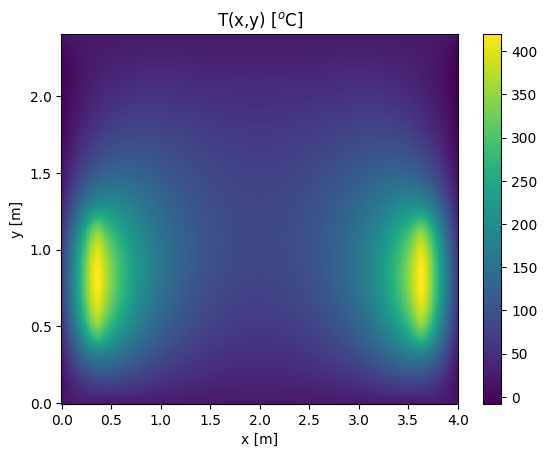

In [8]:
plt.figure(1)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,Tr);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('T(x,y) [$^o$C]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

Pour l'ordinateur sur lequel ce code a été roulé (15,8 Gb de RAM), la plus petite valeur de d possible est d =. Cette limitation vient du fait que pour ce pas, le calcul nécessitera plus de RAM que l'ordinateur (plus que 16Gb). Pour cette valeur de pas, la valeur la plus précise de Tm est de Tm = et son erreur associée est de Err = .

## 2)

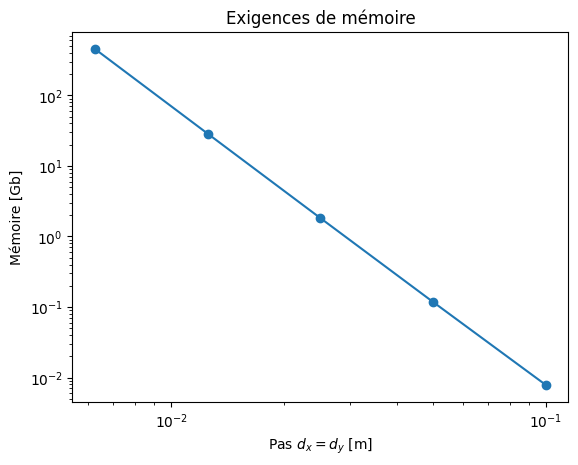

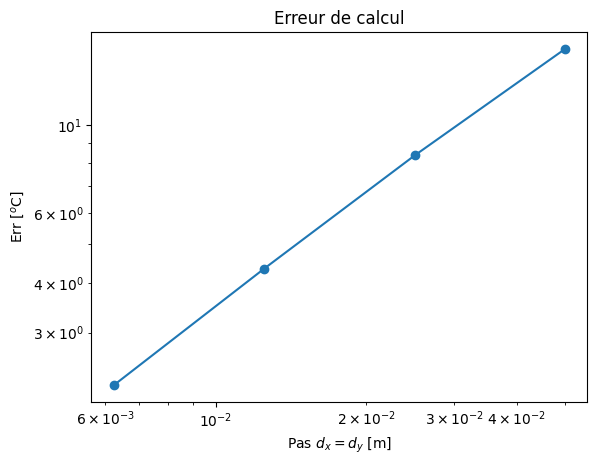

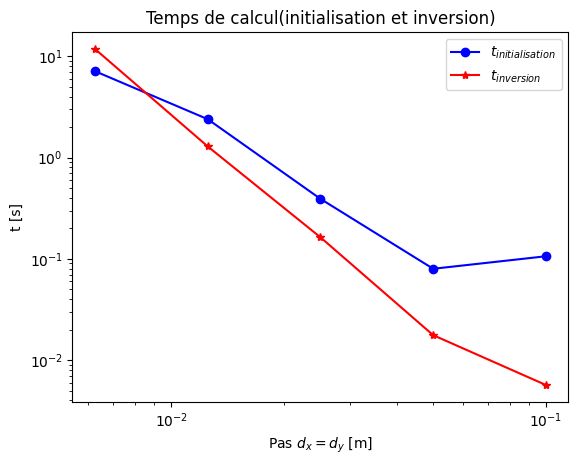


=== Résultats numériques ===
Pas (cm)   T_m (°C)    Mémoire (octets)
  10.000    113.600        8405000
   5.000     98.103      126023688
   2.500     89.738     1951125512
   1.250     85.393    30705393672
   0.625     83.180   487222689800

=== Erreur entre deux pas successifs ===
delta1 (cm)   delta2 (cm)   Err (°C)
  10.000       5.000     15.4968
   5.000       2.500      8.3650
   2.500       1.250      4.3456
   1.250       0.625      2.2131

=== Résultats du maillage ===
delta = 0.1000 m => Nx=41, Ny=25, mem=8.40e+06 octets, t_ini=0.106s, t_inv=0.00567s, Tm=114°C
delta = 0.0500 m => Nx=81, Ny=49, mem=1.26e+08 octets, t_ini=0.0798s, t_inv=0.0176s, Tm=98.1°C
delta = 0.0250 m => Nx=161, Ny=97, mem=1.95e+09 octets, t_ini=0.391s, t_inv=0.163s, Tm=89.7°C
delta = 0.0125 m => Nx=321, Ny=193, mem=3.07e+10 octets, t_ini=2.39s, t_inv=1.29s, Tm=85.4°C
delta = 0.0063 m => Nx=641, Ny=385, mem=4.87e+11 octets, t_ini=7.13s, t_inv=11.8s, Tm=83.2°C

=== Ajustement mémoire : mem ~ A * N^p ===


In [9]:

plt.figure(1)
plt.loglog(d_ar[::-1],mem_ar[::-1]/1024.0**3,'-o')
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')
plt.show()

plt.figure(3)
Err_ar=abs(Tm_ar[:-1:]-Tm_ar[1::]);
d_Err_ar=d_ar[1::]; # Definiton d'erreur Err(delta)=|Tm(2*delta)-Tm(delta)|
plt.loglog(d_Err_ar[::-1],Err_ar[::-1],'-o')
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')
plt.show()

plt.figure(4)
plt.loglog(d_ar[::-1],tini_ar[::-1],'-bo',d_ar[::-1],tinv_ar[::-1],'-r*')
plt.title('Temps de calcul(initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend(['$t_{initialisation}$','$t_{inversion}$'])
plt.show()

print("\n=== Résultats numériques ===")
print("Pas (cm)   T_m (°C)    Mémoire (octets)")
for i in range(fact_ar.size):
    d_cm = d_ar[i]*100
    Tm   = Tm_ar[i]
    mem_bytes = mem_ar[i]
    print(f"{d_cm:8.3f}   {Tm:8.3f}   {mem_bytes:12.0f}")


print("\n=== Erreur entre deux pas successifs ===")
print("delta1 (cm)   delta2 (cm)   Err (°C)")
for i in range(fact_ar.size - 1):
    d1_cm = d_ar[i]*100
    d2_cm = d_ar[i+1]*100
    print(f"{d1_cm:8.3f}    {d2_cm:8.3f}    {Err_ar[i]:8.4f}")

print("\n=== Résultats du maillage ===")
for i in range(fact_ar.size):
    print(f"delta = {d_ar[i]:.4f} m => Nx={int(np.rint(Lx/d_ar[i]+1))}, Ny={int(np.rint(Ly/d_ar[i]+1))}, "
          f"mem={mem_ar[i]:.2e} octets, t_ini={tini_ar[i]:.3g}s, t_inv={tinv_ar[i]:.3g}s, Tm={Tm_ar[i]:.3g}°C")

# Tableau N_ar = Nx * Ny
N_ar = np.zeros(fact_ar.size, dtype=np.double)
for i in range(fact_ar.size):
    Nx_ = int(np.rint(Lx/d_ar[i]+1))
    Ny_ = int(np.rint(Ly/d_ar[i]+1))
    N_ar[i] = Nx_*Ny_

# Ajustement mémoire en log-log
logN = np.log(d_ar)
logMem = np.log(mem_ar)

coeff_mem = np.polyfit(logN, logMem, 1)
p_mem = coeff_mem[0]
A_mem = np.exp(coeff_mem[1])

print(f"\n=== Ajustement mémoire : mem ~ A * N^p ===")
print(f"p_mem = {p_mem:.3f}, A_mem = {A_mem:.3e}")

# Ajustement t_ini en log-log
logTini = np.log(tini_ar)
coeff_tini = np.polyfit(logN, logTini, 1)
p_tini = coeff_tini[0]
A_tini = np.exp(coeff_tini[1])

print(f"\n=== Ajustement t_ini : t_ini ~ A * N^p ===")
print(f"p_tini = {p_tini:.3f}, A_tini = {A_tini:.3e}")

# Ajustement t_inv en log-log
logTinv = np.log(tinv_ar)
coeff_tinv = np.polyfit(logN, logTinv, 1)
p_tinv = coeff_tinv[0]
A_tinv = np.exp(coeff_tinv[1])

print(f"\n=== Ajustement t_inv : t_inv ~ A * N^p ===")
print(f"p_tinv = {p_tinv:.3f}, A_tinv = {A_tinv:.3e}")

# Ajustement erreur (si on veut en fonction de delta)
# 1 point de moins dans Err_ar, donc on prend d_ar[1:]
if fact_ar.size > 1:
    logD = np.log(d_ar[1:])
    logErr = np.log(Err_ar)
    coeff_err = np.polyfit(logD, logErr, 1)
    p_err = coeff_err[0]
    A_err = np.exp(coeff_err[1])
    print(f"\n=== Ajustement Erreur : Err ~ A * d^p ===")
    print(f"p_err = {p_err:.3f}, A_err = {A_err:.3e}")

## 3)

In [10]:
# Transformation logarithmique
log_d = np.log(d_ar)
log_mem = np.log(mem_ar)

coeffs = np.polyfit(log_d, log_mem, 1)  # coeffs[0] = b, coeffs[1] = log(a)

# Récupération des coefficients du modèle mem(d) = a * d^b
b = coeffs[0]
a = np.exp(coeffs[1])

mem_extrapol = 2048e9
d_extrapol = (mem_extrapol / a) ** (1 / b)

print(f"Pas estimé pour une mémoire de {mem_extrapol} : d = {d_extrapol:.5f}")

t_ini = A_tini * (d_extrapol ** p_tini)
t_inv = A_tinv * (d_extrapol ** p_tinv)
err_m = A_err * (d_extrapol ** p_err)
print(f"""Pour un pas de d={d_extrapol:.5f}, le temps d'initialisation estimé est de {t_ini},
       le temps d'inversion estimé est {t_inv}, l'erreur est {err_m:.3f}.""")

Pas estimé pour une mémoire de 2048000000000.0 : d = 0.00433
Pour un pas de d=0.00433, le temps d'initialisation estimé est de 11.183766870227648,
       le temps d'inversion estimé est 26.859316286876535, l'erreur est 1.591.
